In [2]:
import pandas as pd

weather_df = pd.read_csv("/content/sample_data/Plant_1_Weather_Sensor_Data.csv")
power_df = pd.read_csv("/content/sample_data/Plant_1_Generation_Data.csv")

print(weather_df.shape)
print(power_df.shape)


(3182, 6)
(68778, 7)


In [4]:
date_format = "%d-%m-%Y %H:%M"

power_df["DATE_TIME"] = pd.to_datetime(
    power_df["DATE_TIME"],
    format=date_format
)

weather_df["DATE_TIME"] = pd.to_datetime(
    weather_df["DATE_TIME"],
    format="%Y-%m-%d %H:%M:%S" # weather_df uses a different format
)

In [5]:
print(power_df["DATE_TIME"].head())
print(power_df["DATE_TIME"].dtype)


0   2020-05-15
1   2020-05-15
2   2020-05-15
3   2020-05-15
4   2020-05-15
Name: DATE_TIME, dtype: datetime64[ns]
datetime64[ns]


In [6]:
merged_df = pd.merge(
    weather_df,
    power_df,
    on=["DATE_TIME", "PLANT_ID"],
    how="inner"
)

print("Merged shape:", merged_df.shape)
print(merged_df.head())


Merged shape: (68774, 11)
   DATE_TIME  PLANT_ID     SOURCE_KEY_x  AMBIENT_TEMPERATURE  \
0 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
1 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
2 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
3 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
4 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   

   MODULE_TEMPERATURE  IRRADIATION     SOURCE_KEY_y  DC_POWER  AC_POWER  \
0           22.857507          0.0  1BY6WEcLGh8j5v7       0.0       0.0   
1           22.857507          0.0  1IF53ai7Xc0U56Y       0.0       0.0   
2           22.857507          0.0  3PZuoBAID5Wc2HD       0.0       0.0   
3           22.857507          0.0  7JYdWkrLSPkdwr4       0.0       0.0   
4           22.857507          0.0  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    

In [7]:
print(merged_df.head())

   DATE_TIME  PLANT_ID     SOURCE_KEY_x  AMBIENT_TEMPERATURE  \
0 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
1 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
2 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
3 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   
4 2020-05-15   4135001  HmiyD2TTLFNqkNe            25.184316   

   MODULE_TEMPERATURE  IRRADIATION     SOURCE_KEY_y  DC_POWER  AC_POWER  \
0           22.857507          0.0  1BY6WEcLGh8j5v7       0.0       0.0   
1           22.857507          0.0  1IF53ai7Xc0U56Y       0.0       0.0   
2           22.857507          0.0  3PZuoBAID5Wc2HD       0.0       0.0   
3           22.857507          0.0  7JYdWkrLSPkdwr4       0.0       0.0   
4           22.857507          0.0  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0

In [8]:
merged_df["hour"] = merged_df["DATE_TIME"].dt.hour
merged_df["dayofyear"] = merged_df["DATE_TIME"].dt.dayofyear  # optional


In [9]:
merged_df = merged_df[merged_df["IRRADIATION"] > 0]


In [10]:
merged_df = merged_df[merged_df["DC_POWER"] > 0]


In [11]:
merged_df = merged_df.dropna(subset=[
    "IRRADIATION",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "DC_POWER"
])


In [12]:
merged_df = merged_df[
    (merged_df["IRRADIATION"] < 1200) &
    (merged_df["MODULE_TEMPERATURE"] < 80) &
    (merged_df["AMBIENT_TEMPERATURE"] < 60)
]


In [13]:
final_df = merged_df[[
    "hour",
    "IRRADIATION",
    "AMBIENT_TEMPERATURE",
    "MODULE_TEMPERATURE",
    "DC_POWER"
]]

final_df = final_df.rename(columns={
    "DC_POWER": "expected_power"
})


In [14]:
final_df["IRRADIATION"] = final_df["IRRADIATION"] * 1000


In [15]:
final_df.to_csv("cleaned_expected_power_dataset.csv", index=False)
# or

print("✅ Final ML-ready dataset saved")


✅ Final ML-ready dataset saved


In [16]:
final_df = final_df.reset_index(drop=True)


In [17]:
X = final_df[
    ["hour", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]
]

y = final_df["expected_power"]


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=50,     # lightweight
    max_depth=8,        # controls memory
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("✅ Model training completed")


✅ Model training completed


In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE (Watts):", mae)
print("R² Score:", r2)


MAE (Watts): 320.652436748215
R² Score: 0.9774366410997853


In [21]:
final_df["expected_power"].describe()


,expected_power
count,36823.000000
mean,5877.956222
std,3791.911014
min,8.750000
25%,2364.803572
50%,5969.000000
75%,8889.214286
max,14471.125000


In [22]:
import joblib

joblib.dump(model, "expected_power_model.pkl")
print("✅ Model saved as expected_power_model.pkl")


✅ Model saved as expected_power_model.pkl


In [23]:
import pandas as pd

sample_df = pd.DataFrame([{
    "hour": 12,
    "IRRADIATION": 850,
    "AMBIENT_TEMPERATURE": 32,
    "MODULE_TEMPERATURE": 45
}])

prediction = model.predict(sample_df)
print("Predicted Expected Power:", prediction[0], "W")


Predicted Expected Power: 10899.545251570898 W


In [24]:
y_test_pred = model.predict(X_test)


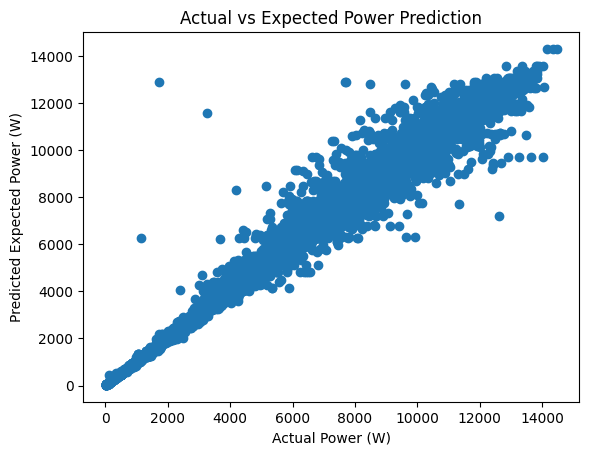

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Actual Power (W)")
plt.ylabel("Predicted Expected Power (W)")
plt.title("Actual vs Expected Power Prediction")

plt.show()


In [26]:
analysis_df = final_df.copy()
analysis_df

,hour,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,expected_power
0,6,5.886957,24.088446,22.206757,37.142857
1,6,5.886957,24.088446,22.206757,53.500000
2,6,5.886957,24.088446,22.206757,58.000000
3,6,5.886957,24.088446,22.206757,58.428571
4,6,5.886957,24.088446,22.206757,54.375000
...,...,...,...,...,...
36818,18,7.006890,23.840239,22.968658,79.000000
36819,18,7.006890,23.840239,22.968658,75.714286
36820,18,7.006890,23.840239,22.968658,77.428571
36821,18,7.006890,23.840239,22.968658,74.857143


In [27]:
X_all = analysis_df[
    ["hour", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]
]

analysis_df["predicted_expected_power"] = model.predict(X_all)


In [28]:
analysis_df["power_loss_W"] = (
    analysis_df["predicted_expected_power"]
    - analysis_df["expected_power"]
)


In [29]:
analysis_df["power_loss_percent"] = (
    (analysis_df["predicted_expected_power"] - analysis_df["expected_power"])
    / analysis_df["predicted_expected_power"] * 100
)
analysis_df["power_loss_percent_clipped"] = (
    analysis_df["power_loss_percent"].clip(lower=0)
)

In [30]:
threshold = analysis_df["power_loss_percent_clipped"].quantile(0.95)


In [31]:
analysis_df["loss_flag"] = (
    analysis_df["power_loss_percent_clipped"] > threshold
)

In [32]:
print("Loss threshold:", threshold)
print(analysis_df["loss_flag"].value_counts())

Loss threshold: 12.29610968374977
loss_flag
False    34981
True      1842
Name: count, dtype: int64


In [33]:
loss_summary = analysis_df["loss_flag"].value_counts()
print(loss_summary)


loss_flag
False    34981
True      1842
Name: count, dtype: int64


In [34]:
analysis_df["power_loss_percent"].describe()


,power_loss_percent
count,36823.000000
mean,0.082630
std,8.119514
min,-104.632375
25%,-3.788564
50%,-0.430610
75%,3.611151
max,90.883672


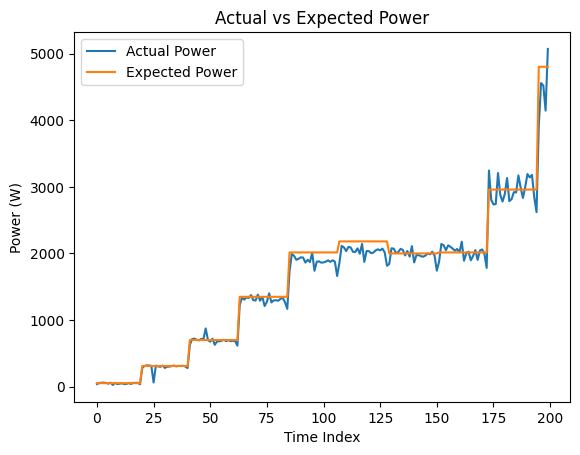

In [35]:
import matplotlib.pyplot as plt

sample_df = analysis_df.iloc[:200]

plt.figure()
plt.plot(sample_df["expected_power"].values, label="Actual Power")
plt.plot(sample_df["predicted_expected_power"].values, label="Expected Power")

plt.xlabel("Time Index")
plt.ylabel("Power (W)")
plt.title("Actual vs Expected Power")
plt.legend()
plt.show()


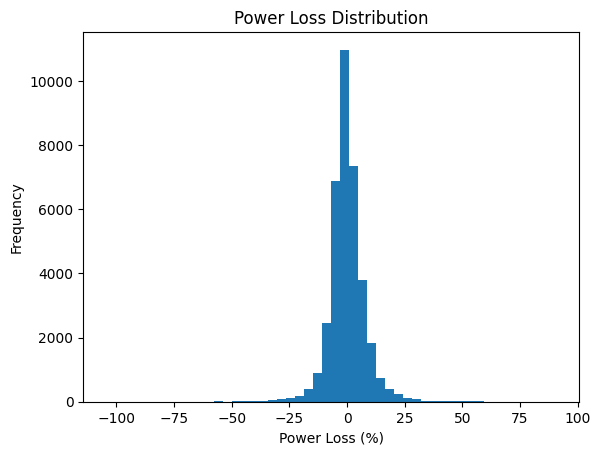

In [36]:
plt.figure()
plt.hist(analysis_df["power_loss_percent"], bins=50)
plt.xlabel("Power Loss (%)")
plt.ylabel("Frequency")
plt.title("Power Loss Distribution")
plt.show()


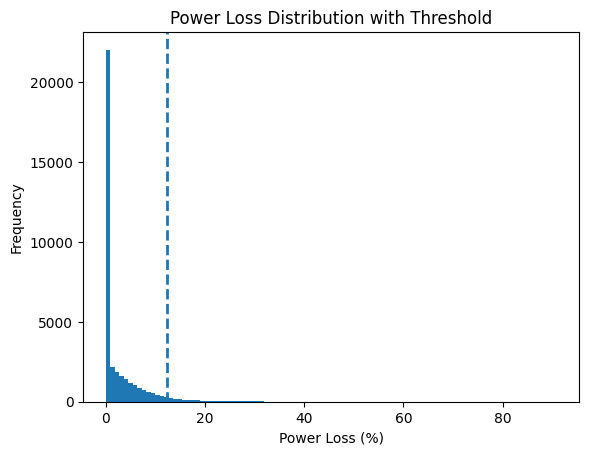

In [37]:
#validation
#1.
import matplotlib.pyplot as plt

plt.figure()
plt.hist(
    analysis_df["power_loss_percent_clipped"],
    bins=100
)

plt.axvline(
    threshold,
    linestyle="--",
    linewidth=2
)

plt.xlabel("Power Loss (%)")
plt.ylabel("Frequency")
plt.title("Power Loss Distribution with Threshold")

plt.show()


In [38]:
#2.
flag_ratio = analysis_df["loss_flag"].mean() * 100
print(f"Percentage of data flagged as loss: {flag_ratio:.2f}%")


Percentage of data flagged as loss: 5.00%


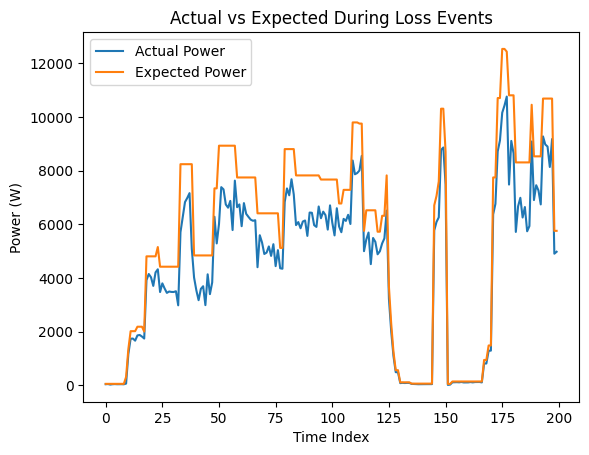

In [40]:
#3.
loss_samples = analysis_df[analysis_df["loss_flag"]].iloc[:200]

plt.figure()
plt.plot(loss_samples["expected_power"].values, label="Actual Power")
plt.plot(loss_samples["predicted_expected_power"].values, label="Expected Power")

plt.legend()
plt.title("Actual vs Expected During Loss Events")
plt.xlabel("Time Index")
plt.ylabel("Power (W)")
plt.show()



In [41]:
#4.
half = len(analysis_df) // 2

t1 = analysis_df.iloc[:half]["power_loss_percent_clipped"].quantile(0.95)
t2 = analysis_df.iloc[half:]["power_loss_percent_clipped"].quantile(0.95)

print("Threshold part 1:", t1)
print("Threshold part 2:", t2)


Threshold part 1: 13.023715455268135
Threshold part 2: 11.547899476092546


In [42]:
#5.
old_threshold = 15  # example

old_flags = (analysis_df["power_loss_percent_clipped"] > old_threshold).mean() * 100
new_flags = (analysis_df["power_loss_percent_clipped"] > threshold).mean() * 100

print("Old threshold flagged (%):", old_flags)
print("New threshold flagged (%):", new_flags)


Old threshold flagged (%): 3.2696955707030932
New threshold flagged (%): 5.00230833989626


In [43]:
LOSS_THRESHOLD = threshold


In [44]:
HIGH_IRRADIATION = analysis_df["IRRADIATION"].quantile(0.6)


In [45]:
analysis_df["dust_candidate"] = (
    (analysis_df["power_loss_percent_clipped"] > LOSS_THRESHOLD) &
    (analysis_df["IRRADIATION"] > HIGH_IRRADIATION)
)


In [46]:
analysis_df["dust_persistent"] = (
    analysis_df["dust_candidate"]
    .rolling(window=8, min_periods=5)
    .mean() > 0.6
)


In [47]:
analysis_df["dust_detected"] = analysis_df["dust_persistent"]


In [48]:
analysis_df["dust_detected"].value_counts()


,count
dust_detected,
False,36720
True,103


In [49]:
dust_samples = analysis_df[analysis_df["dust_detected"]]

dust_samples.head(10)


,hour,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,expected_power,predicted_expected_power,power_loss_W,power_loss_percent,power_loss_percent_clipped,loss_flag,dust_candidate,dust_persistent,dust_detected
352,10,670.675372,28.632192,52.547736,6739.500000,8929.997254,2190.497254,24.529652,24.529652,True,True,True,True
353,10,670.675372,28.632192,52.547736,6619.250000,8929.997254,2310.747254,25.876237,25.876237,True,True,True,True
354,10,670.675372,28.632192,52.547736,8841.375000,8929.997254,88.622254,0.992411,0.992411,False,False,True,True
355,10,670.675372,28.632192,52.547736,6873.000000,8929.997254,2056.997254,23.034691,23.034691,True,True,True,True
356,10,670.675372,28.632192,52.547736,8507.125000,8929.997254,422.872254,4.735413,4.735413,False,False,True,True
375,10,572.283477,28.768913,47.633738,6390.000000,7745.615775,1355.615775,17.501717,17.501717,True,True,True,True
376,10,572.283477,28.768913,47.633738,8140.000000,7745.615775,-394.384225,-5.091709,0.000000,False,False,True,True
462,11,585.787214,30.216062,50.006989,6141.750000,7821.950880,1680.200880,21.480586,21.480586,True,True,True,True
463,11,585.787214,30.216062,50.006989,5567.375000,7821.950880,2254.575880,28.823703,28.823703,True,True,True,True
464,11,585.787214,30.216062,50.006989,7360.714286,7821.950880,461.236594,5.896695,5.896695,False,False,True,True


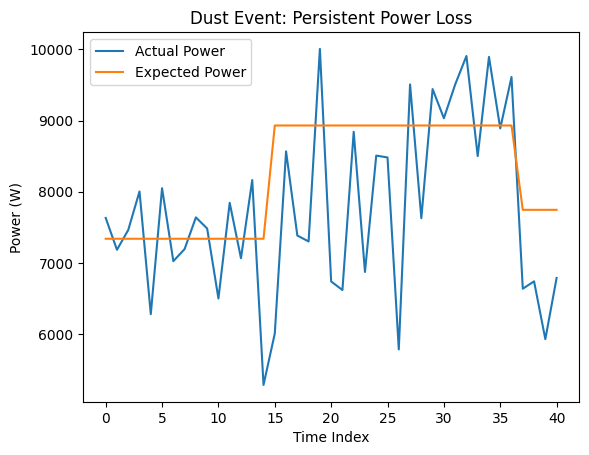

In [51]:
idx = dust_samples.index[0]

window = analysis_df.loc[idx-20 : idx+20]

import matplotlib.pyplot as plt

plt.figure()
plt.plot(window["expected_power"].values, label="Actual Power")
plt.plot(window["predicted_expected_power"].values, label="Expected Power")

plt.title("Dust Event: Persistent Power Loss")
plt.xlabel("Time Index")
plt.ylabel("Power (W)")
plt.legend()
plt.show()


In [52]:
def is_dust_detected(row):
    return bool(row["dust_detected"])

# Example
print(is_dust_detected(dust_samples.iloc[0]))


True


In [53]:
edge_summary = {
    "date": "2026-01-15",
    "dust_detected": True,
    "avg_loss_percent": 18.4,
    "max_loss_percent": 32.1
}


In [54]:
weather_api_response = {
    "rain_expected": True,     # True / False
    "rain_in_hours": 18        # hours from now
}


In [55]:
def cleaning_recommendation(edge_summary, weather):
    if not edge_summary["dust_detected"]:
        return {
            "action": "NO_ACTION",
            "reason": "No dust detected"
        }

    if weather["rain_expected"] and weather["rain_in_hours"] <= 24:
        return {
            "action": "POSTPONE_CLEANING",
            "reason": "Rain expected soon, natural cleaning likely"
        }

    return {
        "action": "CLEAN_NOW",
        "reason": "Dust detected and no rain expected"
    }


In [56]:
decision = cleaning_recommendation(
    edge_summary,
    weather_api_response
)
print(decision)


{'action': 'POSTPONE_CLEANING', 'reason': 'Rain expected soon, natural cleaning likely'}


In [57]:
#dust + no run
weather_api_response["rain_expected"] = False

decision = cleaning_recommendation(
    edge_summary,
    weather_api_response
)
print(decision)


{'action': 'CLEAN_NOW', 'reason': 'Dust detected and no rain expected'}


In [58]:
#no dust
edge_summary["dust_detected"] = False

decision = cleaning_recommendation(
    edge_summary,
    weather_api_response
)
print(decision)


{'action': 'NO_ACTION', 'reason': 'No dust detected'}


In [59]:
analysis_df = merged_df.copy()


In [60]:
X_all = analysis_df[
    ["hour", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]
]

analysis_df["predicted_expected_power"] = model.predict(X_all)

analysis_df["power_loss_percent_clipped"] = (
    (analysis_df["predicted_expected_power"] - analysis_df["DC_POWER"])
    / analysis_df["predicted_expected_power"] * 100
).clip(lower=0)


In [61]:
analysis_df["DATE_TIME"] = pd.to_datetime(analysis_df["DATE_TIME"])


In [62]:
# Sort by time
analysis_df = analysis_df.sort_values("DATE_TIME")

# Compute time difference in hours
analysis_df["interval_hours"] = (
    analysis_df["DATE_TIME"].diff().dt.total_seconds() / 3600
)

# Fill first NaN safely
analysis_df["interval_hours"] = analysis_df["interval_hours"].fillna(
    analysis_df["interval_hours"].median()
)


In [63]:
analysis_df["energy_Wh"] = (
    analysis_df["predicted_expected_power"] *
    analysis_df["interval_hours"]
)


In [64]:
analysis_df["date"] = analysis_df["DATE_TIME"].dt.date

daily_energy_forecast = (
    analysis_df
    .groupby("date")["energy_Wh"]
    .sum()
    .reset_index()
)

daily_energy_forecast["energy_kWh"] = (
    daily_energy_forecast["energy_Wh"] / 1000
)

daily_energy_forecast.head()


,date,energy_Wh,energy_kWh
0,2020-05-15,307.573441,0.307573
1,2020-05-16,602.592864,0.602593
2,2020-05-17,602.592864,0.602593
3,2020-05-18,608.869873,0.608870
4,2020-05-19,590.038846,0.590039


Testing


In [69]:
from google.colab import files
import os

notebook_name_found = None

# Search for .ipynb files, prioritizing /content/ where Colab notebooks are typically stored
for directory in ['/content/', '.']:
    for filename in os.listdir(directory):
        if filename.endswith('.ipynb'):
            notebook_name_found = os.path.join(directory, filename)
            break
    if notebook_name_found: # If found in the current directory, break out
        break

if notebook_name_found:
    print(f"Downloading: {notebook_name_found}")
    files.download(notebook_name_found)
else:
    print("Could not find any .ipynb file to download in /content/ or the current directory.")
    print("Please make sure your notebook is saved and you've specified the correct filename if it's not 'Untitled.ipynb' or similar.")

Could not find any .ipynb file to download in /content/ or the current directory.
Please make sure your notebook is saved and you've specified the correct filename if it's not 'Untitled.ipynb' or similar.


In [50]:
sample = dust_samples.iloc[0]

print("Hour:", sample["hour"])
print("Irradiation:", sample["IRRADIATION"])
print("Actual Power:", sample["expected_power"])
print("Expected Power:", sample["predicted_expected_power"])
print("Loss %:", sample["power_loss_percent_clipped"])
print("Dust detected:", sample["dust_detected"])


Hour: 10
Irradiation: 670.675372
Actual Power: 6739.5
Expected Power: 8929.997254364818
Loss %: 24.529652047699606
Dust detected: True
